In [58]:
%matplotlib inline

import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_columns', 500)

import seaborn as sns

from sklearn import cross_validation, ensemble, tree, linear_model, svm, metrics

# 1. Problem formulation/statement

## Scope

*“Using machine learning methods is it possible to predict as early as possible if a person coming into ER will require hospitalization?”*

This is a narrow scope, our initial scope was broader but we discarded ideas such as predicting which ward the patient would have to go to and if the patient eventually would need intensive care. Although we think that the latter two are really essential to have any real benefit we determined it to be out scope of this study mainly as we are on a very tight schedule. 

## What do we want to predict and the term in-patient
The focus of this study is to try to predict as early as possible if a person coming into ER will need to be hospitalised. In that case the person becomes an In-patient. 

## Benefits of the prediction 

In short - better care faster - and explained:

A normal ER pipeline for an in-patient could look like this (timings taken from dataset means unless otherwise is noted)

Activity|Timing
--------|--------
Arrival|0m
Triage by nurse| 20m
Doctors initial examination| 1h 8m
Blood tests| 1h 35m
Doctors examination after tests| 2h assumed
Doctors decision (inpatient vs other ) | 2h 15m 
Departure| 4h 46m
              
If viewed with an harsh eye you could assumed that you will spend your hours waiting as patient. We want to show if it is possible with the help of machine learning methods to give an early warning to receiving wards and hence have more effective hospital logistics, one effect of that is that the patients probably will have better care in shorter time from specialist wards rather than in the ER which will have to be able to cater for all kinds of maladies but can be experts in very few. The patient will also most probably feel less stress and anxiety caused by the extended waiting periods.

## From resource focus to flow focus
The hospital region for this study have an outspoken goal that they want to move the care process from being focused on using its resources most effectively at the expense of increased waiting times for patients to lean processes where patient needs drives the care process. 



# 2. About the dataset and ER domain knowledge

## Dataset introduction
The main dataset is the ER - log, also called akutliggaren. In the ER log patients are tracked from when they enter the ER until they exit the ER. The data in the ER log have been extracted from the hospital's main system for  keeping electronic medical records and covers the majority of the ER wards in the reception area. An ETL process extracts data from the source system every night and stores the extract in Microsoft SQL server. For use in this project data has then been exporeted to pipe separated text files that can be directly imported in Python.

The exact features of the ER log can be found in the projects data dictionary. One of the more important fields of the ER log is the field First in-patient care unit (ForstaSlutenvardVardenhetID) , which tells us if a person has become an in-patient in connection with the recorded, in the ER-log, visit and that field also gives us the name and type of the ward.

Below a sample dashboard that is in use today displayed on a large wall screen in the ER department. The dashboard show the main flows in the Er department. The steps tracked in each flow is

* Waiting
* Present
  - More than 8h (Subset of Present)
  - Ready but in need of further hospital care (Subset of Present)

Placements done (this is shown by department and the purpose is that every department can show the inbound flow of patients from the ER).

Swedish terms on the dashboard have been translated into English (green text)

<img src="images/screen.png">

## Triage feature discretization
Triage features in the dataset has been discretizationazed already in the source system using a common reference table. To simplify downstream handling of triage variables we normalize them by subtracting one less than the min value from every triage variable value.

See also https://en.wikipedia.org/wiki/Discretization_of_continuous_features

## Inpatient cost vs outpatient cost
We can use the patient costs downstreams when setting up cost matrixes. In general we find that being able to "convert" findings to money is good as it is a general measure that most people can understand and relate to which simplifies any narrative when presenting the outcomes.  


### Sweden University hospital Cost Info

In-patient cost|2014
--------|--------
Average cost/case| 68 505 SEK
Patient age mean| 	52,5 years
Average cost per day|	11 850 SEK ( 1 355 USD )
Average length of stay| 4,8 days
-|-
Out-patient|2014
Average cost/case|3 262 SEK
Patient age mean|	 	46,7 years


source: Sveriges Kommun och Landsting, https://stat.skl.se/kpp/index.htm
(Swedish Association of Local Authorities and Regions)


### US (included for comparison )

State/local government hospitals 2013
Cost per inpatient day 1 878 USD

source: http://www.beckershospitalreview.com/finance/average-cost-per-inpatient-day-across-50-states.html


### Cost of ER visit
The cost for a ER-visit varies between hospitals so we will use an estimaed average of 3 800 SEK.
source: http://www.swenurse.se/contentassets/6cfe05121bce47f7befa4a154af6e7d4/20131022_genomlysning-av-stockholms_akutmottagningar_slutversion.pdf



## Dataset Selection

The chosen dataset contains 2 years of ER - cases from a larger Swedish hospital region, so data is collected from several different ER department. This is both good and bad, the good thing is that we have a decent number of case, the bad thing is that some of them might be specialized for example on children, lighter cases etc which might cause some imbalances in the dataset.

The data selected spans the year 2013 and 2014 and the cases included where selected by arrival time. 
The source data is stored in a relational database and was extracted to comma/pipe separated text before imported and 
used in Python for exploratory analysis and modelling. 

### Basic Data stats

Year | Number of cases
--------|--------
2013| 223 595
2014| 231 208

First visit 2013-01-01 00:02:00.000  
Last visit 2014-12-31 23:58:00.000


### Data quality

The ETL process that extracts data from the hospital's electronic medical records system can have a number 
of bugs affecting the quality of the data. The quality ETL process and the data it produces has not been explored
in this paper.

Furthermore many of the discrete variables (for example all for triaging) have already in the ETL process been discretizationed and "binned". The discretizations done were supervised by domain experts i.e. doctors. We have not explored what implications of using discretizationed vs the original continous will have on the used machine learning methods. The main reason for this is that the continous values where not part of our source dataset.

Finally, we might completely be missing important data affecting our numbers (Gender we are looking at you), we have only got a selected set of features from the source systems and features like journal text, gender, medical history etc are missing.


### Localization
To make the data and our findings more accesible we have spent some time translating all 100+ features to English and creating some helpers for our Python code to incorporate the localization in out Python notebook.

### Colors
Color choices Red and Yellow are taken from the triage color scale where we avoided the combination of Red/Green for the benefits of those with Color Blindness issues. (http://en.wikipedia.org/wiki/Color_blindness) 

## 3. Load data, transform data, feature engineering

#### Load data

In [59]:
data = pd.read_csv('akutliggare.txt', sep='|')

In [60]:
data.tail()

,PatientID,DokumentID,AkutliggareID,PasID,AnkomstsattID,ProblemorsakID,BesoksorsakID,ForstaBesoksorsakID,FlyttadTillVardenhetID,FlyttadTillLokationID,VardbehovID,VardenhetID,ForstaVardenhetID,ForstaSlutenvardVardenhetID,AndraSlutenvardVardenhetID,SenasteKonsulteradeVardenhetID,SenasteAnsvarigaVardenhetID,PrioritetInID,PrioritetUtID,RegistreringsstatusID,AlderID,BesokstypID,DiagnoskodOppenvard,DiagnoskodSlutenvard,Diagnoskod,AndningsfrekvensStatusID,SaturationStatusID,KroppstemperaturStatusID,BlodtryckSystolisktOvreStatusID,BlodtryckDiastolisktNedreStatusID,GCSOgonoppningStatusID,GCSMotorisktStatusID,GCSVerbaltStatusID,StridorStatusID,PulsfrekvensRegelbundenStatusID,PulsfrekvensOregelbundenStatusID,MedvetandegradRettsStatusID,SaturationMedSyrgasStatusID,GCSTotalStatusID,KrampanfallStatusID,LuftvagsstatusRettsStatusID,BLeukocyterStatusID,BErytrocyterStatusID,BHemoglobinStatusID,BEVFStatusID,ErcBMCVStatusID,ErcBMCHStatusID,ErcBMCHCStatusID,BTrombocyterStatusID,PGlukosStatusID,PCRPStatusID,PNatriumStatusID,PKaliumStatusID,PKreatininStatusID,PTroponinTStatusID,AnsvarigtVardlag,KonsulteratVardlag,Klar,TroligInskrivning,Produkttyp,Produktkod,Ankomsttidpunkt,Utskrivningstidpunkt,TidregistreringUtTill,ForstaAnsvarigaLakareTidpunkt,ForstaSkoterskaTidpunkt,SenasteAnsvarigaLakareTidpunkt,SenasteKonsulteradeVardenhetTidpunkt,SenasteAnsvarigaVardenhetTidpunkt,TidTillLakareMinuter,VistelsetidMinuter,VistelsetidPaborjadeTimmar,VantetidTriageMinuter,HandlaggningstidMinuter,Rontgen,RontgenTidTillRemiss,RontgenTidTillUndersokningSlut,RontgenTidTillForstaSvar,Lab,LabTidTillProvtagning,LabTidTillForstaSvar,LabTidTillAnkomstLab,Intensiv,TidTillIntensiv,AntalIntensivInom72Timmar,AntalIn,AntalUt,AntalInvolveradeEnheter,AntalAnsvarigaEnheter,AntalKonsulteradeEnheter,AntalTillLakareInom40Minuter,AntalKlarInom4Timmar,AntalEjKlarInom8Timmar,AntalVistelsetid8Till12Timmar,AntalVistelsetid12Till16Timmar,AntalVistelsetidOver16Timmar,AntalUtanforRettsTidsriktlinje,AntalAterbesokInom72Timmar,AntalBesok,AntalAvlidnaInom7Dagar,AntalAvlidnaInom30Dagar,AntalSlutenvardInom6Timmar,AntalSlutenvardInom12Timmar,AntalDiagnoserOppenvard,AntalDiagnoserSlutenvard,AntalDiagnoser,Alder,SenastUppdaterad,AntalOvernattningar
454798,-2658222856580924101,246966,99468,852080,3272,3795,NaN,NaN,NaN,-91,NaN,38,38,NaN,NaN,NaN,38,NaN,NaN,-1,101,97,NaN,NaN,NaN,3,7,12,19,24,NaN,NaN,NaN,41,45,NaN,54,NaN,NaN,NaN,70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,2014-03-15 14:32:00.000,2014-03-15 15:38:00.000,2014-03-15 15:38:39.000,NaN,NaN,NaN,NaN,2014-03-15 15:52:21.000,NaN,66,2,37,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,0,1,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,"101,25478699999999",2014-03-15 20:01:49.000,0
454799,-2658222856580924101,251563,99469,NaN,3265,3795,NaN,NaN,NaN,-91,NaN,35,35,NaN,NaN,NaN,35,NaN,NaN,-1,101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,2014-04-24 16:29:00.000,2014-04-24 16:33:00.000,2014-04-24 16:33:57.000,NaN,NaN,NaN,NaN,2014-04-24 23:08:12.000,NaN,4,1,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,0,1,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,"101,364373",2014-04-25 20:03:20.000,0
454800,-2658222856580924101,261864,119362,852123,3272,3795,3170,3170,NaN,-91,NaN,38,38,NaN,NaN,NaN,38,NaN,NaN,-1,101,97,NaN,NaN,NaN,2,7,12,18,22,NaN,NaN,NaN,41,44,NaN,NaN,NaN,NaN,NaN,70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,False,NaN,NaN,2014-09-08 08:29:00.000,2014-09-08 09:19:00.000,2014-09-08 09:19:09.000,NaN,NaN,NaN,NaN,2014-09-09 08:21:01.000,NaN,50,1,23,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,0,1,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,"101,739705",2014-09-09 20:04:00.000,0
454801,-2658222856580924101,263780,99470,852126,3266,3795,6862,6862,NaN,-91,4,36,36,NaN,NaN,NaN,36,6,6,-1,101,97,NaN,NaN,NaN,2,8,12,18,22,NaN,NaN,NaN,41,44,NaN,54,NaN,NaN,NaN,70,NaN,NaN,NaN,NaN,NaN,NaN,Na

#### Load the metadata dictionary

In [61]:
# Load comma separated Data Dictionary into memory.
columnMetadata = pd.read_csv('DataDictionary.csv', sep=',')
# Create a dictionary of all columns for easier lookup
columnMetaDictionary = columnMetadata[['Field SV','Field ENG','Field description','Assumed timings']].to_dict()
# We clean up the memory since dataframe will not be necessary
del(columnMetadata)

#### Define a retrieval method to get column metadata from the dictionary

In [62]:
def getColumnAttributeData(srcColumnName,requestedAttributeName,sourceDictionary):
    for ix , colname in sourceDictionary['Field SV'].iteritems():
        if colname == srcColumnName:
            return sourceDictionary[requestedAttributeName][ix]
    return '-'   #not found

#### Test the method with a random column

In [63]:
columnToTest = data.columns[np.random.random_integers(0,len(data.columns)-1,1)]
print columnToTest
print getColumnAttributeData(columnToTest,'Field ENG',columnMetaDictionary)
print getColumnAttributeData(columnToTest,'Field description',columnMetaDictionary)
del(columnToTest)

Index([u'TidTillIntensiv'], dtype='object')
TimeToIntensiveCare
Time to intensive care


#### Translate the column names to English

In [64]:
print 'BEFORE' , data.columns.values
data.rename(columns=lambda x: getColumnAttributeData(x,'Field ENG',columnMetaDictionary), inplace=True)
print 'AFTER' , data.columns.values

BEFORE ['PatientID' 'DokumentID' 'AkutliggareID' 'PasID' 'AnkomstsattID'
 'ProblemorsakID' 'BesoksorsakID' 'ForstaBesoksorsakID'
 'FlyttadTillVardenhetID' 'FlyttadTillLokationID' 'VardbehovID'
 'VardenhetID' 'ForstaVardenhetID' 'ForstaSlutenvardVardenhetID'
 'AndraSlutenvardVardenhetID' 'SenasteKonsulteradeVardenhetID'
 'SenasteAnsvarigaVardenhetID' 'PrioritetInID' 'PrioritetUtID'
 'RegistreringsstatusID' 'AlderID' 'BesokstypID' 'DiagnoskodOppenvard'
 'DiagnoskodSlutenvard' 'Diagnoskod' 'AndningsfrekvensStatusID'
 'SaturationStatusID' 'KroppstemperaturStatusID'
 'BlodtryckSystolisktOvreStatusID' 'BlodtryckDiastolisktNedreStatusID'
 'GCSOgonoppningStatusID' 'GCSMotorisktStatusID' 'GCSVerbaltStatusID'
 'StridorStatusID' 'PulsfrekvensRegelbundenStatusID'
 'PulsfrekvensOregelbundenStatusID' 'MedvetandegradRettsStatusID'
 'SaturationMedSyrgasStatusID' 'GCSTotalStatusID' 'KrampanfallStatusID'
 'LuftvagsstatusRettsStatusID' 'BLeukocyterStatusID' 'BErytrocyterStatusID'
 'BHemoglobinStatusID' '

#### Setup In-patient category column
We use the column First in-patient care unit (ForstaSlutenvardVardenhetID) to categorize patients as In-patients. 
This tells us if a person has become an in-patient in connection with the recorded observation and to predict that is also the goal of our predictive model.

In [65]:
first_care_unit = data.FirstInpatientCareUnitID

data['Inpatient'] = ~first_care_unit.isnull() & (first_care_unit != 0)

In [66]:
data.head()


,PatientID,DocumentID,ERRecordID,PasID,WayOfArrivalID,ProblemCauseID,VisitCauseID,FirstVisitCauseID,MovedToCareUnitID,MovedToLocationID,CareNeedID,CareUnitID,FirstCareUnitID,FirstInpatientCareUnitID,SecondInpatioentCareUnitID,LatestConsultedCareunitID,LatestResponsibleCareUnitID,PriorityInID,PriorityOutID,ResgistrationStatusID,AgeID,VisitTypeID,DiagnoisCodeOutpatientCare,DiagnosisCodeInpatientCare,DiagnosisCode,BreathingFrequencyID,SaturationStatusID,BodyTemperatureID,BloodpressureSystolicUpperID,BloodpressureSystolicLowerID,GCSEyeopeningStatusID,GCSMotoricalStatusID,GCSVerbalStatusID,StridorStatusID,PulsefrequencyRegularID,PulsefrequencyIrregularID,ConsciousnessRettsScaleStatusID,SaturationWithOxygenStatusID,GCSTotalStatusID,KrampsStatusID,AirwaysRettsScaleStatusID,B_LeukocytesStatusID,B_ErytrocytesStatusID,B_HemoglobinStatusID,B_EVFStatusID,Erc_BMCVStatusID,Erc_BMCHStatusID,Erc_BMCCStatusID,B_TrombocytesStatusID,P_GlocuseStatusID,P_CRPStatusID,P_NatriumStatusID,P_KaliumStatusID,P_KreatinStatusID,P_TroponinStatusID,ResponsibleCareTeamID,CosnultedCareTeamID,Done,ExpectedToBecomeInpatient,ProductType,ProductCode,ArrivaltimeToER,DeparturetimeFromER,DepartureRecordingTime,FirstResponsibleDoctorTimestamp,FirstNureTimestamp,LatestDoctorTimestamp,LatestConsultedCareunitTimestamp,LatestResponsiblecareunitTimestamp,TimeUntilMeetingDoctorInMinutes,TimeofStayInMinutes,TimeofStayInHours,TimeUntilTriageInMinutes,CasehandlingInMinutes,Xray,XrayTimeUntilReferral,XrayTimeUntilCompleted,XrayTimeUntilfirstResponse,Lab,LabTimeUntilTesting,LabTimeUntilFirstResponse,LabTimeUntilSampleArrivalAtLab,IntensiveCare,TimeToIntensiveCare,IntensiveCareWith72h,InCount,OutCount,NumberOfInvolvedCareunits,NumberOfResponsibleCareunits,NumberOfConsultedUnits,ToPhysicianWith40minutes,ReadyWith4h,NotReadyWithin8h,Stay8-12h,Stay12-16h,StayMoreThan16h,OutsideRettsTimeGuidelines,ReadmittanceWith72h,NumberOfVisits,DeceasedWithin7days,DeceasedWithin30days,OutpatientWithin6h,OutpatientWithin12h,NumberOfOutpatientDiagnosis,NumberOfInpatientDiagnosis,NumberOfDiagnosis,Age,LatestUpdate,StayoverPatient,Inpatient
0,-9220869629625426145,6,1,373,3266,3795,6863,6863,335,NaN,1,35,35,335,NaN,NaN,35,1,5,-1,50,97,NaN,T519,T519,3,8,12,18,24,NaN,NaN,NaN,41,44,NaN,55,NaN,NaN,NaN,70,4,5,10,12,13,14,15,17,24,25,35,43,44,NaN,2,NaN,True,True,NaN,NaN,2014-07-08 16:49:00.000,2014-07-08 19:16:00.000,2014-07-08 19:16:32.000,2014-07-08 16:51:00.000,2014-07-08 17:02:36.000,2014-07-29 16:59:24.000,NaN,2014-07-29 16:59:24.000,2,147,3,3,145,False,NaN,NaN,NaN,True,4,34,22,False,NaN,0,1,1,1,1,0,1,1,0,0,0,0,1,0,0,0,0,1,1,0,3,3,50,2014-07-29 23:23:08.000,0,True
1,-9220049438171032127,6,2,463,3272,3795,1908,1908,NaN,-92,NaN,557,557,NaN,NaN,NaN,557,NaN,NaN,-1,0,97,NaN,NaN,NaN,NaN,9,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,False,K,Y83O,2014-02-15 17:48:00.000,2014-02-15 17:57:00.000,2014-02-15 17:57:26.000,NaN,NaN,NaN,NaN,2014-02-15 18:45:39.000,NaN,9,1,5,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,0,1,1,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,NaN,0,"0,49039700000000003",2014-02-15 22:33:42.000,0,False
2,-9216200646992851360,6,313724,2804369,3272,3795,3213,3213,NaN,-91,NaN,557,557,NaN,NaN,NaN,557,6,6,-1,6,97,S670,NaN,S670,3,9,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,True,False,K,U98O,2013-05-10 15:48:00.000,2013-05-10 21:43:00.000,2013-05-10 21:44:12.000,2013-05-10 16:55:00.000,2013-05-10 15:50:36.000,2013-05-11 04:05:43.000,NaN,2013-05-11 04:05:43.000,67,355,6,2,288,True,81,161,181,NaN,NaN,NaN,NaN,False,NaN,0,1,1,1,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,NaN,1,"6,4931369999999999",2013-05-11 22:01:06.000,0,False
3,-9210158571153385697,6,313725,2804882,3272,3261,3172,6881,NaN,-91,NaN,434,434,NaN,NaN,785,434,8,8,-1,31,97,S731,NaN,S731,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN

#### Arrival date 
Convert arrival date data type from text to date and create derived columns for weekday, month and day. This is an example of feature engineering where we create to data set column that can be used downstreams. For example we might see some cases where Saturdays or 9 am show up as a strongly predictive feature for becoming in-patient.

In [67]:
import dateutil.parser as duparse

data['ArrivalDate'] = data['ArrivaltimeToER'].map(lambda s: duparse.parse(s))
data['ArrivalHour'] = data['ArrivalDate'].dt.hour
data['ArrivalWeekday'] = data['ArrivalDate'].dt.dayofweek
data['ArrivalMonth'] = data['ArrivalDate'].dt.month

#### Partitioning dataset columns into sub domains

In [68]:
early_columns = ['WayOfArrivalID', 'ProblemCauseID', 'VisitCauseID', 'AgeID',
                   'ArrivalHour', 'ArrivalWeekday', 'ArrivalMonth','AgeCluster']


triage_columns = ['TimeUntilTriageInMinutes','BreathingFrequencyID', 'SaturationStatusID', 'BodyTemperatureID', 
                   'BloodpressureSystolicUpperID', 'BloodpressureSystolicLowerID', 'GCSEyeopeningStatusID',
                   'GCSMotoricalStatusID', 'GCSVerbalStatusID', 'StridorStatusID', 'PulsefrequencyRegularID',
                   'PulsefrequencyIrregularID', 'ConsciousnessRettsScaleStatusID', 'SaturationWithOxygenStatusID','PriorityInID']


lab_columns = ['LabTimeUntilFirstResponse','B_LeukocytesStatusID','B_ErytrocytesStatusID','B_HemoglobinStatusID',
               'B_EVFStatusID','Erc_BMCVStatusID','Erc_BMCHStatusID','Erc_BMCCStatusID','B_TrombocytesStatusID',
               'P_GlocuseStatusID','P_CRPStatusID','P_NatriumStatusID','P_KaliumStatusID','P_KreatinStatusID','P_TroponinStatusID']


input_columns = early_columns + triage_columns

output_column = 'Inpatient'

#### Transform triage categories
Change value cell values from x to x-(xmin-1), this is just to make them more readable in our plots. As mentioned before the values are already discretized in the source file, so all we do is to align the class values to left.

In [69]:
#  aligning triage data classes
for col in triage_columns:
    data[col] = data[col] - (data[col].min() - 1)

#### Miscellaneous transformations

The Swedish input file stores Age is a decimal number with the regional , format in between the digits, so we replace , by . to get it to the international convention and then rounding off it and converting to integer.

Once we do that, we would like to perform a simple clustering based on the age data distribution in order to find natural groups. After some iterations of tests, 4 seems to be a good cluster target count, which seperates the outliers into an isolated category.

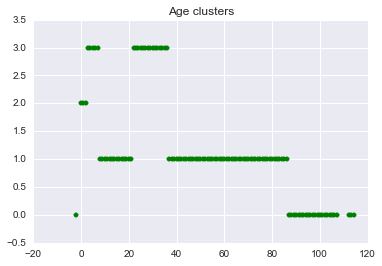

In [70]:
# convert age to number
data['Age'] = data[~data.Age.isnull()].Age.map(lambda a: int(round(float(str(a).replace(',', '.')))))
# get the age counts
countsPerGroup = pd.DataFrame(data.groupby('Age').size()).reset_index()

from sklearn.cluster import KMeans
# cluster the values
kmeans = KMeans(init='k-means++', n_clusters=4, n_init=1000)
kmeans.fit(countsPerGroup)
countsPerGroup['AgeCluster'] = countsPerGroup.index.map(lambda a: int(round(kmeans.labels_[a])))
# save the cluster value as a feature
data = pd.merge(data,countsPerGroup[['Age','AgeCluster']],left_on='Age', right_on='Age',how='left')
plt.title("Age clusters")
plt.scatter(countsPerGroup['Age'],countsPerGroup['AgeCluster'],color="green")
plt.show()

#### Copy of minimally transformed data set for downstream use    


In [71]:
#why two copies here: one is imputed, for graphs etc that are sensitive to NANs, one is more pure very close to source data
# which can be used for comparisons etc 
dataclean = data.copy() 
dataraw = data.copy()

#### Imputation
Replace NaNs and nulls with -10 so that libraries which don't work well with NaNs will accept our dataset

In [72]:
for col in input_columns:
    is_null = data[col].isnull()
    data.loc[is_null, col] = -10   
for col in lab_columns:
    is_null = data[col].isnull()
    data.loc[is_null, col] = -10
    
print dataclean['SaturationStatusID'].min()    
for col in input_columns:
    is_null = dataclean[col].isnull()
    dataclean.loc[is_null, col] = dataclean[col].min()-1    
    

1.0


# 4. Setup test and training datasets

After a few iterations of different combinations, we found the random 20% to 80% respectively test data to training data split as a good range to have decent amount of training data and not overfitting our models. We will furthermore resort cross-validation, which will further be explained in later sections.

In [73]:
np.random.seed(921)
mask = np.random.choice([0, 1], data.shape[0], p=[0.2, 0.8])

test_data = data[mask == 0].copy()
train_data = data[mask == 1].copy()

# 5. EDA

The Er Log the project has access to 100+ fields and one defensive initial idea where to focus on the triage data. The first examination plus the medical history of the patient are what nurses and doctor are using to assess the status of a patient and also to give a patient an initial priority. Many Swedish hospital is using Retts (http://predicare.se/en/om-retts/) decision support system for emergency medicine when assessing the patients and at the time of assessment a number of vital parameters are collected. 

            
In that way the project piggy rides on the domain knowledge of the organisation and try to use features that they use. We will see if that is a good or bad idea, but we can always extend with more features later on. We only have access to the ER log and not the medical history of the patients and there already from the beginning we have some limitations that most probably will affect the precision of our predictions. In addition to that we do not get the “touch and feel” a nurse and doctor get’s when talking to a patient, they can use their hands to feel body temperature, sweating and pinpoint things like abdominal pains etc.

The vital parameters that we have access to are 

* Breathing frequency
* Saturation Status
* Body temperature 
* Bllodpressure Systolic Upper 
* Blood pressure Systolic Lower 
* GCS Eye opening Status 
* GCS Motoric Status
* GCS Verbal Status
* Stridor Status
* Pulse frequency regular
* Pulse frequency irregular 
* Consciousness Retts scale status 
* Saturation with oxygen status

In addition to that we will use patient Age and hopefully Gender (Gender was not part of the initial dataset )
(by Kostya. We actually can use time of the day and month of the year as predictors, I am sure there're seasonal
changes in different diagnoses)

We aim to predict if a patient will need further care and become an Inpatient. The diagram below shows the relation between Inpatients and Others. Others include people going home  and outpatients. The main difference between an outpatient and an inpatient from a hospital logistics perspective is that the inpatients stays overnight and requires more resources. An outpatient may have an appointment at the hospital for example the following day or a week later for check up but their direct interaction (and use of resources) with the hospital is relatively brief.

## Time phased features
The goal is to predict in-patient vs other as early as possible, therefore we divided the features according to when in the process they were recorded/occured. For example a patient age becomes known as soon as they arrive at the ER, the breathing frequency at triage, blood test values after the return of lab tests etc. 

The most important time phases for the project are the early ones like

- Arrival
- Triage
- Lab tests/doctors medical exam

A full separation into time phases has been done in the data dictionary.

The different time phases can also be used to show how a ML prediction models result changed over time and hopefully the predictions improve as later features are added to the feature test.





## Inpatient / Outpatient distribution - a case of an imbalanced data set

In [74]:
ct = pd.crosstab(data['ArrivalDate'].dt.year, data['Inpatient'])
ct.index.name = 'ArrivalYear'
ct

Inpatient,False,True
ArrivalYear,,
2013,178728,44867
2014,186020,45188


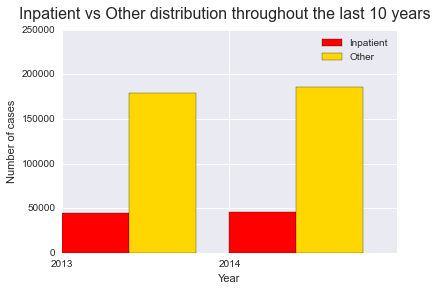

In [75]:
plt.bar(ct.index.values, ct[True], width=0.4, color='red', label='Inpatient')
plt.bar(ct.index.values + 0.4, ct[False], width=0.4, color='gold', label='Other')
plt.xticks(ct.index.values, ct.index.values)
plt.xlabel('Year')
plt.ylabel('Number of cases')
plt.ylim(0,250000)
plt.suptitle('Inpatient vs Other distribution throughout the last 10 years', fontsize=16)

plt.legend()
plt.show()

> Please note that both 2006 and 2008's data is incomplete in the original dataset.

> #### Team ER Analysis
The above plot shows that we have an class imbalanced problem with our unbalanced data set where 20% are In-patients and 80% belong to the class Other. We need to have that in mind when we look at the output from our predictors. In general we should look to other evaluators of our methods than just accuracy and also time given evaluate alternative strategies such as up/down sampling the majority class.

>On a side note this also shows how a rather simple plot can give important insights.

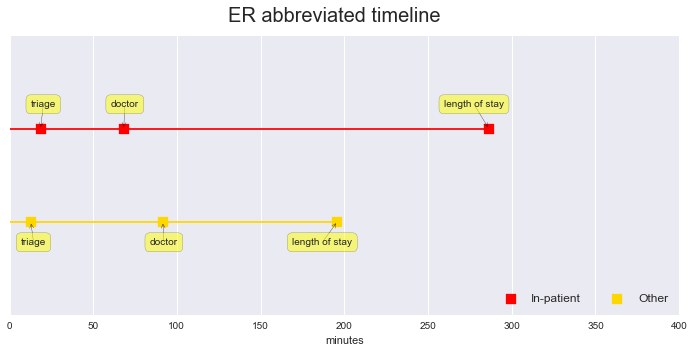

In [76]:
# Statistics for narrative - Inpatient waiting times

# collect inpatient means
x1data = data[data['Inpatient'] == 1][['TimeUntilTriageInMinutes','TimeUntilMeetingDoctorInMinutes','TimeofStayInMinutes']].mean()

# collect other means
x2data =  data[data['Inpatient'] == 0][['TimeUntilTriageInMinutes','TimeUntilMeetingDoctorInMinutes','TimeofStayInMinutes']].mean()

values = [1,2]

X1 = x1data.values
Y1 = [10,10,10]
LX1 = np.insert(X1,0,0)
LY1 = [10,10,10,10]

X2 = x2data.values
Y2 = [5,5,5]

LX2 = np.insert(X2,0,0)
LY2 = [5,5,5,5]

fig, ax = plt.subplots(figsize=(12,5))
pi = ax.scatter(X1, Y1, color="red",
           marker='s', s=100)
plt.plot(LX1, LY1,color="red")
po = ax.scatter(X2, Y2, color="gold",
           marker='s', s=100)
plt.plot(LX2, LY2,color="gold")
#fig.autofmt_xdate()

fig.suptitle('ER abbreviated timeline ', fontsize=20)

ax.set_xlabel('minutes')

#  turning off stuff that's plotted by default

ax.yaxis.set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')


ax.get_yaxis().set_ticklabels([])
#day = pd.to_timedelta("1", unit='D')
plt.xlim(0, 400)
plt.ylim(0, 15)


# annotate bonanza
#http://stackoverflow.com/questions/5147112/matplotlib-how-to-put-individual-tags-for-a-scatter-plot
plt.annotate(
        "triage", 
        xy = (X1[0], 10), xytext = (15, 20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

plt.annotate(
        "doctor", 
        xy = (X1[1], 10), xytext = (15, 20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

plt.annotate(
        "length of stay", 
        xy = (X1[2], 10), xytext = (15, 20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

plt.annotate(
        "triage", 
        xy = (X2[0], 5), xytext = (15, -25),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

plt.annotate(
        "doctor", 
        xy = (X2[1], 5), xytext = (15, -25),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

plt.annotate(
        "length of stay", 
        xy = (X2[2], 5), xytext = (15, -25),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

plt.legend((pi, po),
           ('In-patient', 'Other'),
           scatterpoints=1,
           loc='lower right',
           ncol=3,
           fontsize=12)

plt.show()

> #### Team ER Analysis 
Under the assumption that In-patients have more severe problems than the Other the above, the timeline looks strange. Why would the ER triage Others before In-patient? We think that it is probably that the triage is recorded later for In-patient i.e. longer time was spent doing the actual triage than for Other patients. This highlights a problem with this study, <u>we can not differentiate the time when an activity was recorded from the time it when it actually occured, in addition we often have only one timestamp for an activity and miss the duration of the activity.</u>

The rest of the timeline looks ok, the more severe the earlier you see a doctor but the longer the length of stay as it takes the hospital sometime to open up a hospital bed 

In [77]:

# Omitted as it requiers us to expose patient id, but kept to explain some reasoning in cost matrix

# Outpatient revisiting ER to become inpatients
# This is a little bit simplified algoritm so the actual
# result will be slightly lower as we should really look for patients
# becoming inpatients within 72h, but it still tells a story of the people revisiting within 72h almost 
# a 1/3 was in the end admitted as inpatients.
#outp72h = data[(data['Inpatient'] == 0) & (data['ReadmittanceWith72h']==1)]
#dfResult = pd.merge(data,outp72h,how='inner',on='PatientID',suffixes=('','72h'))
#print len(dfResult[(dfResult['Inpatient'] == 1) & (dfResult['Inpatient'] > dfResult['Inpatient72h'])])
#ReadmittanceWith72h    41108
#dtype: int64
#30071


## Summary statistics of different predictor columns



In [78]:
dataclean[input_columns].describe()

,WayOfArrivalID,ProblemCauseID,VisitCauseID,AgeID,ArrivalHour,ArrivalWeekday,ArrivalMonth,AgeCluster,TimeUntilTriageInMinutes,BreathingFrequencyID,SaturationStatusID,BodyTemperatureID,BloodpressureSystolicUpperID,BloodpressureSystolicLowerID,GCSEyeopeningStatusID,GCSMotoricalStatusID,GCSVerbalStatusID,StridorStatusID,PulsefrequencyRegularID,PulsefrequencyIrregularID,ConsciousnessRettsScaleStatusID,SaturationWithOxygenStatusID,PriorityInID
count,454803.000000,454803.000000,454803.000000,454803.000000,454803.000000,454803.000000,454803.000000,454803.000000,454803.000000,454803.000000,454803.00000,454803.000000,454803.000000,454803.000000,454803.000000,454803.000000,454803.000000,454803.000000,454803.000000,454803.000000,454803.000000,454803.000000,454803.000000
mean,3302.575594,3899.653331,4131.827338,36.332117,13.360688,2.820676,6.450940,1.622916,16.183561,1.650040,2.87816,2.349318,1.842728,1.816974,0.047330,0.072625,0.058520,0.595871,1.526470,0.098887,0.417741,0.040048,6.144150
std,359.991142,504.369074,2055.263737,27.058579,5.583621,1.989926,3.461387,0.913538,52.030419,1.539793,1.74351,1.560810,1.814352,1.832852,0.429202,0.652578,0.531929,0.914436,1.621613,0.605065,0.518677,0.340670,1.650562
min,3265.000000,3258.000000,262.000000,-1.000000,0.000000,0.000000,1.000000,-1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3272.000000,3795.000000,3140.000000,11.000000,10.000000,1.000000,3.000000,1.000000,2.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000
50%,3272.000000,3795.000000,3170.000000,34.000000,13.000000,3.000000,6.000000,1.000000,10.000000,2.000000,4.00000,3.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000
75%,3272.000000,3795.000000,6861.000000,58.000000,18.000000,4.000000,9.000000,3.000000,21.000000,2.000000,4.00000,3.000000,3.000000,4.000000,0.000000,0.000000,0.000000,2.000000,3.000000,0.000000,1.000000,0.000000,7.000000
max,10455.000000,8773.000000,12811.000000,113.000000,23.000000,6.000000,12.000000,3.000000,28926.000000,5.000000,4.00000,5.000000,5.000000,5.000000,4.000000,6.000000,5.000000,2.000000,6.000000,6.000000,4.000000,3.000000,8.000000


#### Observation of the arrival times

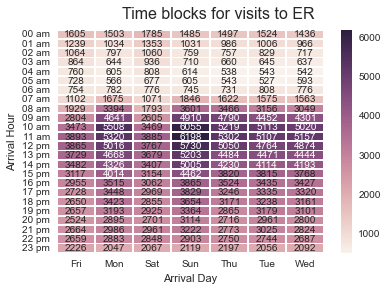

In [79]:
countsPerGroup = pd.DataFrame(dataclean.groupby(['ArrivalHour','ArrivalWeekday']).size()).reset_index()
countsPerGroup.rename(columns={0:'Number of cases'}, inplace=True)
countsPerGroup['ArrivalWeekday'] = countsPerGroup['ArrivalWeekday'].map(
    lambda d: ['Sun','Mon','Tue','Wed','Thu','Fri','Sat'][d]) 
countsPerGroup['ArrivalHour'] = countsPerGroup['ArrivalHour'].map(
    lambda h: ('%d pm' % h) if h>=12 else ("%d am" % h).zfill(5)) 
sns.heatmap(countsPerGroup.pivot("ArrivalHour", "ArrivalWeekday", "Number of cases"),linewidths=.85,
            annot=True, fmt="d")
plt.ylabel('Arrival Hour')
plt.xlabel('Arrival Day')
plt.suptitle('Time blocks for visits to ER', fontsize=16)
plt.show()

> #### Team ER Analysis

> Interestingly, most visits take place earlier in the morning on sundays or mondays. 0 - 7 am is not as heavily loaded as we expected.

Let us see if there is anything interesting in terms of inpatient vs other outcomes based on the same features

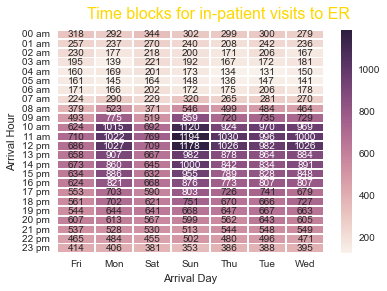

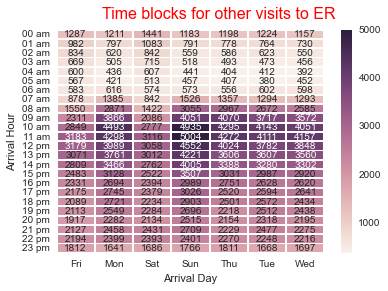

In [80]:
countsPerGroup = pd.DataFrame(
    dataclean[dataclean['Inpatient']==1].groupby(['ArrivalHour','ArrivalWeekday']).size()).reset_index()
countsPerGroup.rename(columns={0:'Number of cases'}, inplace=True)
countsPerGroup['ArrivalWeekday'] = countsPerGroup['ArrivalWeekday'].map(
    lambda d: ['Sun','Mon','Tue','Wed','Thu','Fri','Sat'][d]) 
countsPerGroup['ArrivalHour'] = countsPerGroup['ArrivalHour'].map(
    lambda h: ('%d pm' % h) if h>=12 else ("%d am" % h).zfill(5)) 
sns.heatmap(countsPerGroup.pivot("ArrivalHour", "ArrivalWeekday", "Number of cases"),linewidths=.85,annot=True, 
            fmt="d")
plt.ylabel('Arrival Hour')
plt.xlabel('Arrival Day')
plt.suptitle('Time blocks for in-patient visits to ER', fontsize=16,color="Gold")
plt.show()
countsPerGroup = pd.DataFrame(
    dataclean[dataclean['Inpatient']==0].groupby(['ArrivalHour','ArrivalWeekday']).size()).reset_index()
countsPerGroup.rename(columns={0:'Number of cases'}, inplace=True)
countsPerGroup['ArrivalWeekday'] = countsPerGroup['ArrivalWeekday'].map(
    lambda d: ['Sun','Mon','Tue','Wed','Thu','Fri','Sat'][d]) 
countsPerGroup['ArrivalHour'] = countsPerGroup['ArrivalHour'].map(
    lambda h: ('%d pm' % h) if h>=12 else ("%d am" % h).zfill(5)) 
sns.heatmap(countsPerGroup.pivot("ArrivalHour", "ArrivalWeekday", "Number of cases"),
            linewidths=.85,annot=True, fmt="d")
plt.ylabel('Arrival Hour')
plt.xlabel('Arrival Day')
plt.suptitle('Time blocks for other visits to ER', fontsize=16,color="Red")
plt.show()

> #### Team ER Analysis

> The same pattern applies to both classes. Weekdays and hours of visits are hardly predictive to distinguish between a potential inpatient or other outcome.

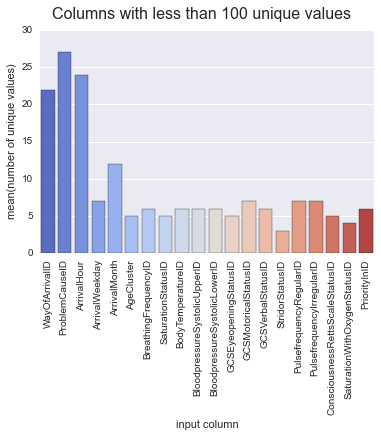

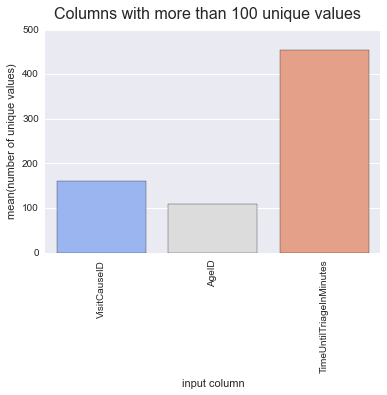

In [81]:
unqcountslist = []
for col in input_columns:
    unqcounts = {}
    unqcounts['input column'] = col
    unqcounts['number of unique values'] = len(pd.unique(dataclean[col].ravel()))
    unqcountslist.append(unqcounts)
uniquevaluecounts = pd.DataFrame(unqcountslist)
del(unqcountslist)
sns.barplot(x='input column', y='number of unique values', ci=None, palette="coolwarm",
            data=uniquevaluecounts[uniquevaluecounts['number of unique values']<100])
plt.suptitle('Columns with less than 100 unique values', fontsize=16)
plt.xticks(rotation="vertical")
sns.despine(left=True, bottom=True)
plt.show()
sns.barplot(x='input column', y='number of unique values', ci=None, palette="coolwarm",
            data=uniquevaluecounts[uniquevaluecounts['number of unique values']>=100])
plt.suptitle('Columns with more than 100 unique values', fontsize=16)
plt.xticks(rotation="vertical")
sns.despine(left=True, bottom=True)
plt.show()


> #### Team ER Analysis

> Almost all of the input columns have less than 30 distinct categorical values. Causes of visit and age and time until triage have more unique values.

## Distribution of predictor columns by inpatient status

In [82]:
dataclean[input_columns].describe()

,WayOfArrivalID,ProblemCauseID,VisitCauseID,AgeID,ArrivalHour,ArrivalWeekday,ArrivalMonth,AgeCluster,TimeUntilTriageInMinutes,BreathingFrequencyID,SaturationStatusID,BodyTemperatureID,BloodpressureSystolicUpperID,BloodpressureSystolicLowerID,GCSEyeopeningStatusID,GCSMotoricalStatusID,GCSVerbalStatusID,StridorStatusID,PulsefrequencyRegularID,PulsefrequencyIrregularID,ConsciousnessRettsScaleStatusID,SaturationWithOxygenStatusID,PriorityInID
count,454803.000000,454803.000000,454803.000000,454803.000000,454803.000000,454803.000000,454803.000000,454803.000000,454803.000000,454803.000000,454803.00000,454803.000000,454803.000000,454803.000000,454803.000000,454803.000000,454803.000000,454803.000000,454803.000000,454803.000000,454803.000000,454803.000000,454803.000000
mean,3302.575594,3899.653331,4131.827338,36.332117,13.360688,2.820676,6.450940,1.622916,16.183561,1.650040,2.87816,2.349318,1.842728,1.816974,0.047330,0.072625,0.058520,0.595871,1.526470,0.098887,0.417741,0.040048,6.144150
std,359.991142,504.369074,2055.263737,27.058579,5.583621,1.989926,3.461387,0.913538,52.030419,1.539793,1.74351,1.560810,1.814352,1.832852,0.429202,0.652578,0.531929,0.914436,1.621613,0.605065,0.518677,0.340670,1.650562
min,3265.000000,3258.000000,262.000000,-1.000000,0.000000,0.000000,1.000000,-1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3272.000000,3795.000000,3140.000000,11.000000,10.000000,1.000000,3.000000,1.000000,2.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000
50%,3272.000000,3795.000000,3170.000000,34.000000,13.000000,3.000000,6.000000,1.000000,10.000000,2.000000,4.00000,3.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000
75%,3272.000000,3795.000000,6861.000000,58.000000,18.000000,4.000000,9.000000,3.000000,21.000000,2.000000,4.00000,3.000000,3.000000,4.000000,0.000000,0.000000,0.000000,2.000000,3.000000,0.000000,1.000000,0.000000,7.000000
max,10455.000000,8773.000000,12811.000000,113.000000,23.000000,6.000000,12.000000,3.000000,28926.000000,5.000000,4.00000,5.000000,5.000000,5.000000,4.000000,6.000000,5.000000,2.000000,6.000000,6.000000,4.000000,3.000000,8.000000


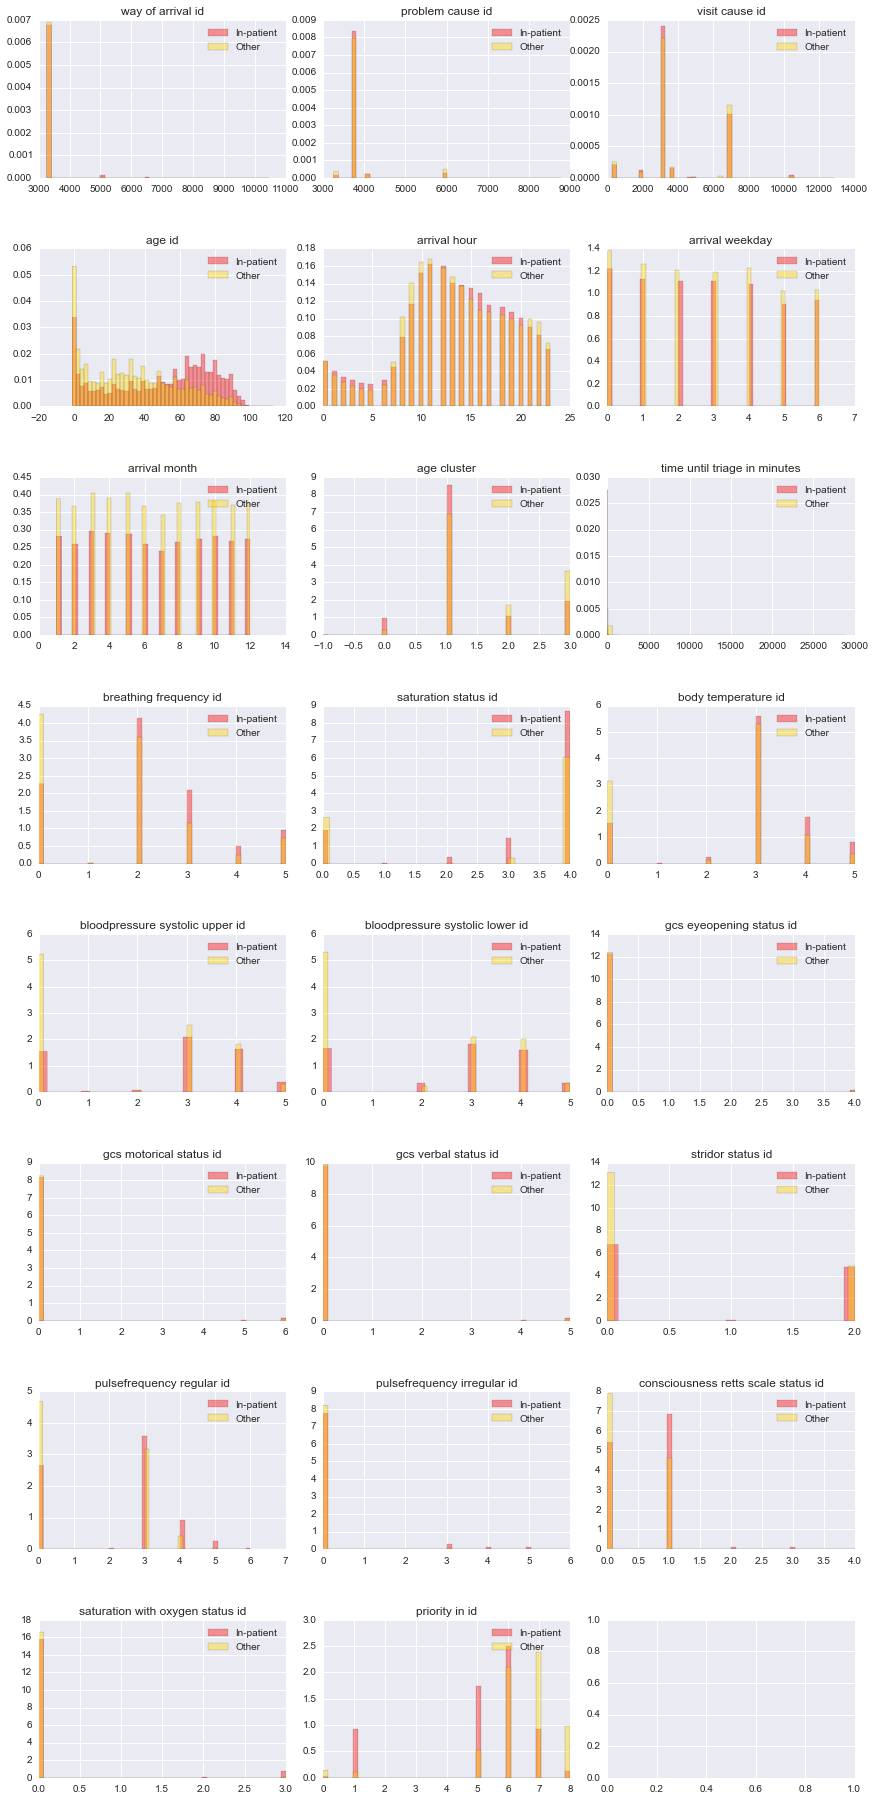

In [83]:
# http://stackoverflow.com/questions/1175208/elegant-python-function-to-convert-camelcase-to-camel-case
import re
def pretty(name):
    s1 = re.sub('(.)([A-Z][a-z]+)', r'\1 \2', name)
    return re.sub('([a-z0-9])([A-Z])', r'\1 \2', s1).lower()

def plot_column(ax, col):
    #sns.kdeplot(dataclean[col][dataclean.Inpatient == 1],ax=ax)
    sns.distplot(dataclean[col][dataclean.Inpatient == 1] , kde=False, ax=ax,axlabel=False, label='In-patient', norm_hist=True,color='Red')
    sns.distplot(dataclean[col][dataclean.Inpatient == 0] , kde=False, ax=ax,axlabel=False, label='Other', norm_hist=True,color='Gold')
    ax.set_title(pretty(col), horizontalalignment='center')
    ax.legend()

fig, axes = plt.subplots(nrows=8, ncols=3, sharex=False, sharey=False, figsize=(12, 25))
 
fig.tight_layout(h_pad=5)

for ax, col in zip(axes.ravel(), input_columns):
    plot_column(ax, col)

> #### Team ER Analysis

>Almost all columns, have substantially different distributions for both cases. The most promising vars, i.e. which seem to have substantially different distributions for both cases are:

>* BreathingFrequencyID
>* BloodpressureSystolicUpperID
>* BloodpressureSystolicLowerID
>* StridorStatusID
>* Age




In [84]:
promising_inputs = ['BreathingFrequencyID', 'BloodpressureSystolicUpperID', 
                    'BloodpressureSystolicLowerID', 'StridorStatusID', 'Age']

## Pairplot

Let's draw a pairplot for the most promising vars. We use a sample from the data bacause sns.pairplot doesn't work well a large number of points. 

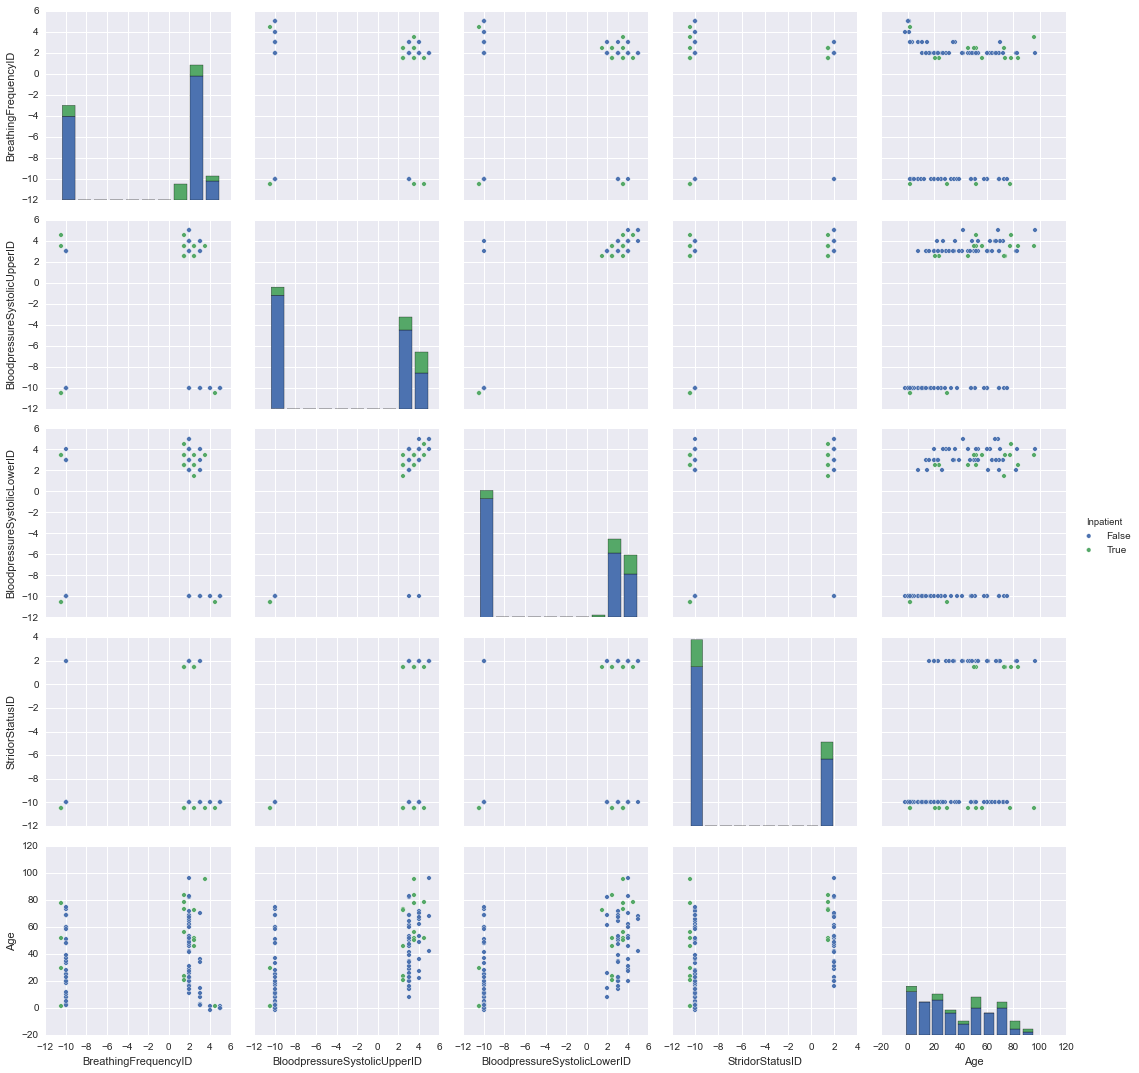

In [85]:
sample_data = train_data.sample(n=100, replace=True, random_state=72)

# introduce some noise so that all plots not end up on top of each other
noise = 0.5

for col in promising_inputs:
    rowinpatient = sample_data.Inpatient == 1
    sample_data.loc[rowinpatient, col] = sample_data.loc[rowinpatient, col] - noise

#colors = ["green", "red"]

sns.pairplot(sample_data, vars=promising_inputs, hue='Inpatient', size=3)

>#### Team ER Analysis
On the pairplots we see that there're some places when we see one kind of patients more often than others. However, nothing conclusive can be made from this chart. Here we can also identify a visualisation problem with plotting discretionaized variables that end up on top of each other, indtroducing noise improved the graphs but still nothing conclusive to made from the plots.

## A case of missing values 
Missing data impacts learning, inference, and prediction (in relation to machine learning methods). 

Two base categories of missing data: 

* Data that is missing at random
Randomly missing data can be ignores and inference can be based on the observed data only. 

    
* Data that is not missing at random
Ignoring missing data leads to bias, one reason is that some features depend on each other
    
These base categories can be divided further into sub categories but the point here 
is that it is very hard to prove that data is randomly missing so we need a method to deal with the missing data. Also most classifiers have no natural ability to deal with missing data.

References:
http://www.cs.toronto.edu/~marlin/research/phd_thesis/marlin-phd-thesis.pdf, Benjamin M. Marlin, Page 1

http://www.stat.columbia.edu/~gelman/arm/missing.pdf


### Project strategies for missing values

   
    
#### Complete case analysis
Delete all cases where we do not have full data. The problem with this is that we would introduce bias, a practical example from this project is that if we would use complete case analysis as a strategy with the features we have selected (primarily variables determined at triage time) we would only have patients who were measured against GCS, Glasgow Coma Scale, and if a patient(case) is so measured they are in most of the cases already in a bad condition so any predictions would be biased.


#### Imputation 
Fill in missing values or with another wording: imputate the values. One easy approach would be to  use the mean but that would have it's own  problems for example that the standard deviation would be underestimated. We can also hook into scikit-learns preprocessing Imputer class to try out various fill in strategies. 


#### Selected strategy
In the end we kept it simple and replaced NAN values with a constant. This should work well with algoritms such as random forrest and a little worse with others as the constants skews values suchs as mean, std deviation etc.

A better startegy could have be to make the assumption that most of the missing values are missing on purpose i.e. you do not measure a patient against the Glasgow Coma Scale (GCS) if they come into the ER with a broken finger. So in that case we would just assume that the patient would end up in the healthiest category of the GCS. Problem with this approach is that it requires some further research and domain knowledge.








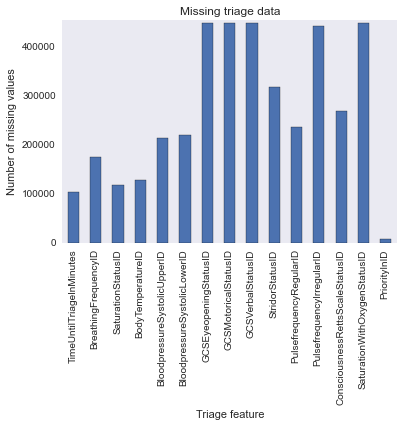

In [86]:
##Missing values in numbers
dfTriage = dataraw[triage_columns]

if len(dfTriage) != len(data):
    print "Data size differs"

# sum missing values
dfTriageMissing =  dfTriage.isnull().sum()

# prepare plot
xticks=dfTriageMissing.index
xvalues=dfTriageMissing.values

plotdata = {'Missing triage data' : pd.Series(xvalues, index=xticks) }
dfPlot = pd.DataFrame(plotdata)

c = 'Missing triage data'
dfPlot[c].plot(kind='bar',title=c)
plt.ylabel('Number of missing values')
plt.xlabel('Triage feature')
plt.grid(False)
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,0,len(dfTriage)))
plt.show()





> #### Team ER Analysis
A lot of the triage features have missing values, probably the best prediction would be to assume that those values are normal and not recorded in the case that are not need on a case to case basis depending on the circumstances.

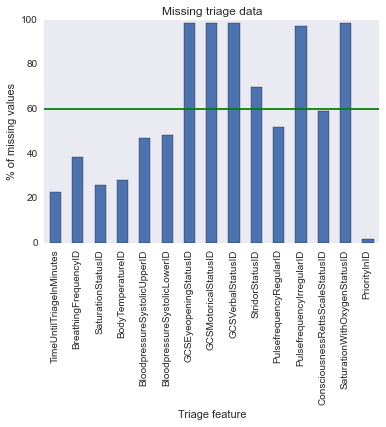

In [87]:
import math
xticks=dfTriageMissing.index
xvalues=(dfTriageMissing.values/(len(dfTriage)*1.0))*100.0


plotdata = {'Missing triage data' : pd.Series(xvalues, index=xticks) }
dfPlot = pd.DataFrame(plotdata)

c = 'Missing triage data'
dfPlot[c].plot(kind='bar',title=c)
plt.ylabel('% of missing values')
plt.xlabel('Triage feature')
plt.grid(False)
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,0,100))
plt.axhline(y=60,color='g')
plt.show()


> #### Team ER Analysis
For benchmarking purposes we did a simple full case analysis (see the appendix Comparison Full cases instead of using imputation method) were we selected the most common triage features (common from the purpose of having a value in the data set) and run some ML methods on that data set. This data set hade fewer records as only "complete" record were used. The performance for the predictors were worse than for other imputation methods. As they were worse we did not pursue this track any further.



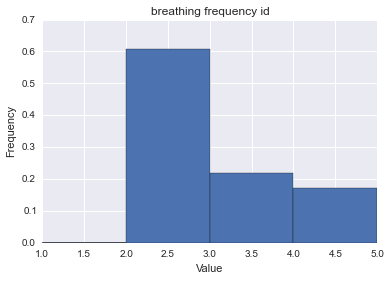

In [88]:
# Show variable distribution before imputation


subdata = dataraw[pd.notnull(data['BreathingFrequencyID'])]
varsubdata = subdata['BreathingFrequencyID']

binwidth = 1
bins=range(min(varsubdata).astype(np.int64), max(varsubdata).astype(np.int64) + binwidth, binwidth)

plt.hist(varsubdata, bins=bins,normed=1, histtype='bar')
plt.title(pretty("BreathingFrequencyID"))
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

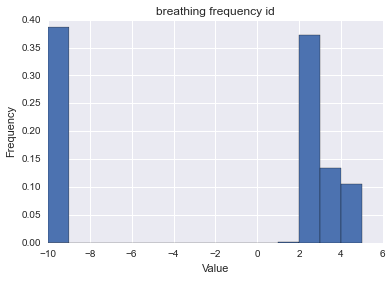

In [89]:
# Show variable distribution after imputation


subdata = data[pd.notnull(data['BreathingFrequencyID'])]
varsubdata = subdata['BreathingFrequencyID']

binwidth = 1
bins=range(min(varsubdata).astype(np.int64), max(varsubdata).astype(np.int64) + binwidth, binwidth)

plt.hist(varsubdata, bins=bins,normed=1, histtype='bar')
plt.title(pretty("BreathingFrequencyID"))
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

# 6. Predictions and analysis

Improvement Prediction, analysis and feature engineering was made interactively by running the ML pipeline, evaluating the outcome and then coming back to the feature engineering to add/remove a feature and run the pipeline again.

let's prepare sklearn compatible input:

In [90]:
from sklearn import preprocessing

# arrival + triage
train_data_in = train_data[input_columns]
train_data_out = train_data[output_column]

test_data_in = test_data[input_columns]
test_data_out = test_data[output_column]

# arrival + triage + lab, used for benchmarking
train_data_in_with_lab = train_data[input_columns+lab_columns]
train_data_out = train_data[output_column]

test_data_in_with_lab = test_data[input_columns+lab_columns]
test_data_out = test_data[output_column]

# arrival + triage with ploinomal features used for benchmarking
train_data_in_poly = train_data[input_columns]
test_data_in_poly = test_data[input_columns]

Xtrain = train_data_in_poly.as_matrix().astype(np.float)
Xtest = test_data_in_poly.as_matrix().astype(np.float)

polynomial_features = preprocessing.PolynomialFeatures()

Xtrain = polynomial_features.fit_transform(Xtrain)
Xtest = polynomial_features.fit_transform(Xtest)

# early
train_data_in_early = train_data[early_columns]
train_data_out_early = train_data[output_column]

test_data_in_early = test_data[early_columns]
test_data_out_early = test_data[output_column]





Utility to train classifiers

In [91]:
# straight forward trainer do a quick evaluation of a ML method
def train(cls, sample_size=-1,inp_train_data=train_data_in,inp_test_data=test_data_in):
    if sample_size == -1:
        inp = inp_train_data
        out = train_data_out
    else:
        indicies = np.arange(len(inp_train_data))
        np.random.shuffle(indicies)
        indicies = indicies[0:(sample_size - 1)]
        
        inp = inp_train_data.iloc[indicies]
        out = inp_train_data.iloc[indicies]
    
    cls.fit(inp, out)
    score = cls.score(inp_test_data, test_data_out)
    return cls, score

In [92]:
# trainer with bells and whistles (cross validation, parameter optimization)
def trainadvanced(clf,all_data, inp_train, inp_test , out_train ,out_test, parameter_optimization_request,n_folds=10):
    
    
    stratified_k_fold = cross_validation.StratifiedKFold(out_train, n_folds=10, shuffle=False)
    if parameter_optimization_request > 0 :
        print 'not here'
        clf = GridSearchCV(clf,param_grid= parameter_optimization_request, cv = stratified_k_fold ,scoring="accuracy")
    y_pred = out_train.copy()
    
    #clf.fit(inp_train,out_train)
    for ii, jj in stratified_k_fold:
        
        
        X_train, X_test = inp_train[ii], inp_train[jj]
        
        #print X_train.shape,y_train.shape
        #y_train = out_train[ii]
        
        y_train = out_train[ii]
        
        clf.fit(X_train,y_train)
        
        y_pred[jj] = clf.predict(X_test)
        #y_pred[jj] = 
        
    #clf.fit(inp_train,out_train)
    #print inp_train.shape,out_train.shape
    y_pred = clf.predict(inp_test)
    score = metrics.accuracy_score(out_test,y_pred)
    return clf , score

As a baseline we consider a model which always predicts that the patient is inpatient. It's not exactly correct, since the cost of sending home a patient who's seriously ill very high. But, we can use it as a simple comparison baseline

In [93]:
1 - np.mean(train_data_out)

0.80195605735278774

## Feature Importance

We used f test to select the most important features.

In [94]:
from sklearn.feature_selection import SelectKBest, f_classif

kbest = SelectKBest(f_classif, k='all')
kbest.fit_transform(train_data_in, train_data_out)

scores = zip(train_data_in.columns.values, kbest.scores_)

for rank, (name, val) in enumerate(sorted(scores, key=lambda p: -p[1])):
    print '{0} : {1} - {2}'.format(rank, name, val)

0 : AgeID - 23258.7838511
1 : BloodpressureSystolicUpperID - 16178.6254018
2 : BloodpressureSystolicLowerID - 14223.2129934
3 : PulsefrequencyRegularID - 11020.7966351
4 : SaturationWithOxygenStatusID - 10664.3865356
5 : BreathingFrequencyID - 10321.2302924
6 : ConsciousnessRettsScaleStatusID - 9744.72960511
7 : PriorityInID - 9300.07461519
8 : AgeCluster - 8858.2964587
9 : BodyTemperatureID - 8004.93102481
10 : PulsefrequencyIrregularID - 6397.50345027
11 : StridorStatusID - 5773.53075443
12 : SaturationStatusID - 4993.81138173
13 : WayOfArrivalID - 842.881984811
14 : TimeUntilTriageInMinutes - 601.398631751
15 : ProblemCauseID - 433.715545097
16 : GCSEyeopeningStatusID - 393.120396006
17 : GCSMotoricalStatusID - 389.271820899
18 : GCSVerbalStatusID - 370.34986478
19 : VisitCauseID - 156.613804008
20 : ArrivalHour - 1.03149029656
21 : ArrivalWeekday - 0.86496716367
22 : ArrivalMonth - 0.329465247799


## Decision tree

In [95]:
decision_tree, dt_score = train(tree.DecisionTreeClassifier())
print dt_score

Xtrain_data_in = train_data_in.as_matrix().astype(np.float)
Xtest_data_in = test_data_in.as_matrix().astype(np.float) 
Xtrain_data_out = train_data_out.as_matrix().astype(np.float)
Xtest_data_out = test_data_out.as_matrix().astype(np.float)

decision_tree, dt_score = trainadvanced(tree.DecisionTreeClassifier(),data,Xtrain_data_in,Xtest_data_in,Xtrain_data_out,Xtest_data_out,
                                       0,10)
print dt_score 
decision_tree_early, dt_score_early = train(tree.DecisionTreeClassifier(), inp_train_data=train_data_in_early,inp_test_data=test_data_in_early)
print dt_score_early



0.768004768159
0.763512544012
0.750355956336


> #### Team ER Analysis - method selection
The decision tree predictor is easy to get up running as it  does some implicit feature selection, isn't sensitive to outliers or missing data, accepts both numerical and categorical data. We used as an initial benchmark for the other methods.



> #### Team ER Analysis - feature selection
For the RF we benchmarked early features vs early+triage features and adding the triage features added to the accuracy.


## Random forests

In [96]:
%%time



# n_jobs -1 use all procs on system for increased execution time

rf, rf_score = train(ensemble.RandomForestClassifier(n_estimators=100,n_jobs=-1),-1,inp_train_data=train_data_in,inp_test_data=test_data_in)
#rf, rf_score = train(ensemble.RandomForestClassifier(n_estimators=10,n_jobs=-1))
#print rf.feature_importances_
print rf_score
print rf.n_features_ 

'''
#rf_lab, rf_score_lab = train(ensemble.RandomForestClassifier(class_weight='subsample'),-1,train_data_in,test_data_in)
#print rf_score_lab

best_score = 0.0
best_combination = 0
for numberOfTrees in range(101,1,-10):
    for maxDepth in [1000]:
        for minSampleSplit in range(100,len(data) +1 ,500000):
            for numFeatures in range(len(input_columns),2,-1):
                rf, rf_score = train(ensemble.RandomForestClassifier(n_estimators=numberOfTrees,
                                                                        max_depth = maxDepth,
                                                                        min_samples_split=minSampleSplit,
                                                                        max_features = numFeatures, n_jobs=-1))
                if rf_score > best_score:
                    best_score = rf_score
                    best_combination = rf
                print (numberOfTrees,maxDepth,minSampleSplit,numFeatures), rf_score
print best_score,best_combination

from sklearn.grid_search import GridSearchCV
parameters = {"n_estimators": range(100,1,-10),"max_depth": [100,1000],"max_features": [19,20,21],"min_samples_split":[100,1000]}
c= GridSearchCV(rf,param_grid= parameters, cv = 5 ,scoring="accuracy")
rf= c.fit(train_data_in, train_data_out)
rf, rf_score = train(rf.best_estimator_)
print rf.get_params()
print rf_score
print rf.n_features_ 

'''

0.838931137625
23
Wall time: 17.9 s


> #### Team ER Analysis - method selection
Random forest (RF) came up during an early group meeting and we decided to try it as it is quite forgiving when implemented and most of the variables are understandable. It also has a feature ranking method (as seen below) which gave some insight to which features that the predictor valued as important. 

One weakness of RF is that it can be biased towards multicategory variables and the effect of this bias could be a reason for the ranking below where "few category" triage features score lower than WayOfArrivalID and ProblemCauseID.


In [97]:
#def plot_feature_imp(rfin,intrain_data)
 
    
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
         axis=0)
indices = np.argsort(importances)[::-1]


fnames = train_data_in.columns.values.tolist()
# Print the feature ranking
print("Feature ranking:")


for f in range(train_data_in.shape[1]):
    print("%d. Feature %d : %s (%f)" % (f + 1, indices[f], fnames[f],importances[indices[f]]))

#Plot the feature importances of the forest
#plt.figure()
#plt.title("Feature importances")
#plt.bar(range(train_data_in.shape[1]), importances[indices],
#       color="r", yerr=std[indices], align="center")
#plt.xticks(range(train_data_in.shape[1]), indices)
#clf.fit(inp_train,out_train)
#plt.xlim([-1, train_data_in.shape[1]])
#plt.show()

Feature ranking:
1. Feature 3 : WayOfArrivalID (0.131492)
2. Feature 8 : ProblemCauseID (0.108315)
3. Feature 4 : VisitCauseID (0.105995)
4. Feature 2 : AgeID (0.103924)
5. Feature 22 : ArrivalHour (0.100443)
6. Feature 6 : ArrivalWeekday (0.088858)
7. Feature 5 : ArrivalMonth (0.069061)
8. Feature 0 : AgeCluster (0.060051)
9. Feature 13 : TimeUntilTriageInMinutes (0.033294)
10. Feature 9 : BreathingFrequencyID (0.030289)
11. Feature 11 : SaturationStatusID (0.028822)
12. Feature 12 : BodyTemperatureID (0.028008)
13. Feature 18 : BloodpressureSystolicUpperID (0.018508)
14. Feature 10 : BloodpressureSystolicLowerID (0.017738)
15. Feature 7 : GCSEyeopeningStatusID (0.015134)
16. Feature 1 : GCSMotoricalStatusID (0.014411)
17. Feature 20 : GCSVerbalStatusID (0.013650)
18. Feature 17 : StridorStatusID (0.013350)
19. Feature 21 : PulsefrequencyRegularID (0.007998)
20. Feature 19 : PulsefrequencyIrregularID (0.005720)
21. Feature 16 : ConsciousnessRettsScaleStatusID (0.001698)
22. Feature 15

## Logistic regression

In [98]:
from sklearn.cross_validation import cross_val_score
log_reg, lr_score = train(linear_model.LogisticRegression())
print "lr-score:",lr_score

#log_reg_lab, lr_score_lab = train(linear_model.LogisticRegression(),-1,train_data_in_with_lab,test_data_in_with_lab)
#print lr_score_lab


probs = log_reg.predict_proba(test_data_in)

in_result = test_data['Inpatient']
yI = np.where(in_result == True,1,0)

y_pred = log_reg.predict(test_data_in)

print "accuracy",metrics.accuracy_score(yI, y_pred)
print "roc_auc_score",metrics.roc_auc_score(yI, probs[:, 1])

scores = cross_val_score(linear_model.LogisticRegression(), test_data_in, yI, scoring='accuracy', cv=10)
print scores
print scores.mean()



lr-score: 0.810686416265
accuracy 0.810686416265
roc_auc_score 0.738876162954
[ 0.80046352  0.80300188  0.80675422  0.80885112  0.81423841  0.81688742
  0.82174393  0.82017883  0.80925047  0.77160835]
0.807297814204


## Linear Support Vector Classification

In [99]:
lsvm_c, lsvm_c_score = train(svm.LinearSVC())
print lsvm_c_score






0.809119104646


## Gradient Boosting Classifier

In [100]:
gbs_c, gbs_c_score = train(ensemble.GradientBoostingClassifier(n_estimators=350))
print gbs_c_score

0.844096643525


## ROC Curves

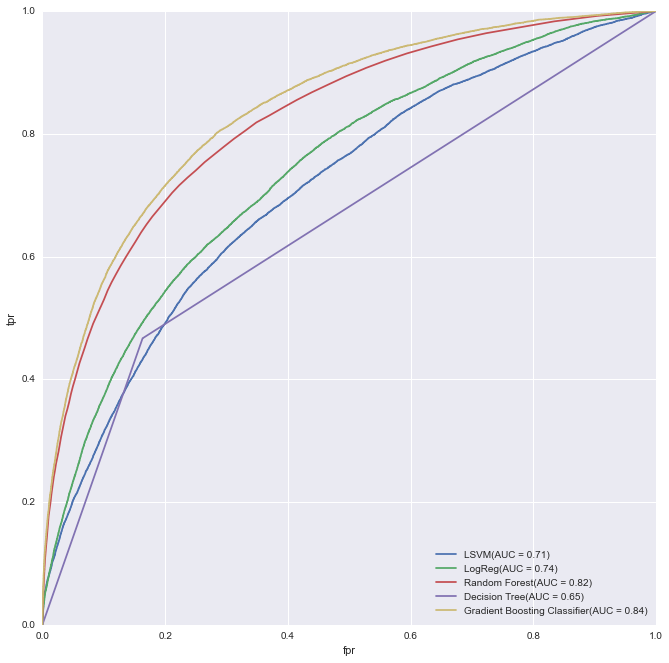

In [101]:
def draw_roc(cls, label):
    if ('predict_proba' in dir(cls)):
        fpr, tpr, thresh = metrics.roc_curve(test_data_out, cls.predict_proba(test_data_in)[:,1])
    else:
        fpr, tpr, thresh = metrics.roc_curve(test_data_out, cls.decision_function(test_data_in))
    auc = metrics.auc(fpr, tpr)

    plt.plot(fpr, tpr, label=(label + '(AUC = {0:.2f})'.format(auc)))

    plt.xlabel('fpr')
    plt.ylabel('tpr')
    plt.xlim([0, 1.0])
    plt.ylim([0, 1.0])
    
    plt.legend(loc='lower right')

    
plt.figure(figsize=(11, 11))
    
draw_roc(lsvm_c, 'LSVM')
draw_roc(log_reg, 'LogReg')
draw_roc(rf, 'Random Forest')
draw_roc(decision_tree, 'Decision Tree')
draw_roc(gbs_c,'Gradient Boosting Classifier')

As we can see from the chart, random forest is the best method. Logistic regression seems to be better on the part of the chart with fpr above 0.8 but not substantially so.

[0 0 0 ..., 0 0 0]
[[69506  3168]
 [11425  6502]]
[[69506  3168]
 [11425  6502]]
[[     0 269280]
 [194225 442136]]


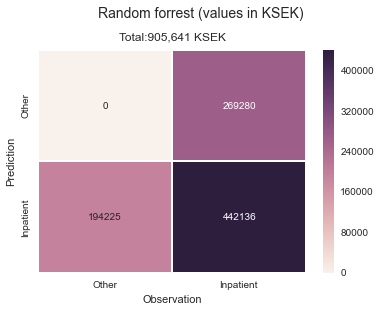

In [172]:
### Intial cost matrix calculations
# http://users.dsic.upv.es/~flip/papers/Cost-ROC-Multidimensiona7.pdf
# http://blog.yhathq.com/posts/predicting-customer-churn-with-sklearn.html

from sklearn.metrics import confusion_matrix

#y = np.array(y)'

#confusion_matrix(y,run_cv(X,y,RF))

def model1cost(arrConf):
        
    arrCost = np.array([[-68000,  3800],
                   [17000,  0]])

    total = 0
    
    
    

    arrCost[0,0] = arrCost[0,0] *  arrConf[0,0] / 1000
    arrCost[0,1] = arrCost[0,1] *  arrConf[0,1] / 1000
    arrCost[1,0] = arrCost[1,0] *  arrConf[1,0] / 1000
    arrCost[1,1] = arrCost[1,1] *  arrConf[1,1] / 1000
    
    
    # TN
    total = total + arrCost[0,0]

    # FN 
    total = total + arrCost[0,1]

    # FP
    total = total + arrCost[1,0]
    
    # TP
    total = total + arrCost[1,1]
    
    
    return arrCost,total

def modeltfcost(arrConf):
        
    arrCost = np.array([[0,  85000],
                   [17000,  68000]])

    total = 0
    
    
    arrCost[0,0] = arrCost[0,0] *  arrConf[0,0] / 1000
    arrCost[0,1] = arrCost[0,1] *  arrConf[0,1] / 1000
    arrCost[1,0] = arrCost[1,0] *  arrConf[1,0] / 1000
    arrCost[1,1] = arrCost[1,1] *  arrConf[1,1] / 1000
    
    
      # TN
    total = total + arrCost[0,0]

    # FN 
    total = total + arrCost[0,1]

    # FP
    total = total + arrCost[1,0]
    
    # TP
    total = total + arrCost[1,1]
    
    return arrCost, total


in_result = test_data['Inpatient']
yI = np.where(in_result == True,1,0)
yO = np.where(in_result == True,0,1)

#print test_data_in.shape
y_pred_rf = rf.predict(test_data_in)
y_pred_decision_tree = decision_tree.predict(test_data_in)
y_pred_log_reg = log_reg.predict(test_data_in)
y_pred_lsvm_c = lsvm_c.predict(test_data_in)

#print len(yI)
#print sum(yI)
#print len(yI)-sum(yI)

#   TN FN
#   FP TP
#carrBaselineI = np.array([[0,  0],
#                   [len(yI)-sum(yI),  sum(yI)]])

#print "Baseline confusion - everybody becomes inpatient"
#print carrBaselineI


#carrBaselineO = np.array([[sum(yO),  len(yO)-sum(yO)],
#                   [0,  0]])

#print "Baseline confusion - nobody becomes inpatient"
#print carrBaselineO

print yI

carr_rf = confusion_matrix(yI,y_pred_rf)
carr_decision_tree = confusion_matrix(yI,y_pred_decision_tree)
carr_log_reg = confusion_matrix(yI,y_pred_log_reg)
carr_lsvm_c = confusion_matrix(yI,y_pred_lsvm_c)


    


#print "Model  confusion"    
#print carr_rf
#print sum(sum(carr_rf))


#print cost(carrBaselineI)

#print cost(carrBaselineO)


#print "Decision tree:",cost(carr_decision_tree)
#print "Random forest:",cost(carr_rf)

#print "Logistic regression:",cost(carr_log_reg)
#print "Lsvm:",cost(carr_lsvm_c)


#draw_confusion_matrices(confusion_matrices,class_names)

# TN
#    total = total + arrCost[0,0] * arrConf[0,0]
# FN 
#    total = total + arrCost[0,1] * arrConf[0,1]
# FP
#    total = total + arrCost[1,0] * arrConf[1,0]
# TP
# total = total + arrCost[1,1] * arrConf[1,1]
    

print carr_rf


cost_rf,totsek = modeltfcost(carr_rf)
print carr_rf
print cost_rf

sns.heatmap(cost_rf,annot=True,fmt='d',linewidths=0.85)
plt.suptitle('Random forrest (values in KSEK)', fontsize=14,y=1.05)
plt.title('Total:' + '{0:,}'.format(totsek)+' KSEK', fontsize=12,y=1.025)
plt.ylabel('Prediction')
plt.xlabel('Observation')
plt.xticks([0.5,1.5], ['Other','Inpatient'])
plt.yticks([0.5,1.5], ['Inpatient','Other'])
plt.show()




## Appendix

## Comparison Full cases instead of using imputation method

In [46]:
# Full cases
# From above we pick all variabels that have at least 40% of filled values 
columns_fullcase = ['BreathingFrequencyID', 'SaturationStatusID', 'BodyTemperatureID', 
                   'BloodpressureSystolicUpperID', 'BloodpressureSystolicLowerID',                     'PulsefrequencyRegularID',
                    'ConsciousnessRettsScaleStatusID','WayOfArrivalID', 'ProblemCauseID', 'VisitCauseID', 'PriorityInID', 'Age',
                   'ArrivalHour', 'ArrivalWeekday', 'ArrivalMonth','Inpatient']


dfFullCase = dataclean[columns_fullcase]

# messy willl rewrite
columns_fullcase = ['BreathingFrequencyID', 'SaturationStatusID', 'BodyTemperatureID', 
                   'BloodpressureSystolicUpperID', 'BloodpressureSystolicLowerID',                     'PulsefrequencyRegularID',
                    'ConsciousnessRettsScaleStatusID','WayOfArrivalID', 'ProblemCauseID', 'VisitCauseID', 'PriorityInID', 'Age',
                   'ArrivalHour', 'ArrivalWeekday', 'ArrivalMonth']



dfFullCase['NoOfMissingData'] = dfFullCase.isnull().sum(axis=1)

#dfFullCase['NoOfMissingData']

dfFullCaseComplete = dfFullCase[dfFullCase['NoOfMissingData'] == 0]
#print len(dfFullCaseComplete)
# 147843
# So we have a subset of 147843 ful cases o work with if we want to
# of course if we add furtherfeatures variables we always need to go 
# bak and see how they affect our full cases count



np.random.seed(921)
mask = np.random.choice([0, 1], dfFullCaseComplete.shape[0], p=[0.1, 0.9])

fulltest_data = dfFullCaseComplete[mask == 0].copy()
fulltrain_data = dfFullCaseComplete[mask == 1].copy()

C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [47]:
# Test full case

train_data_in_full = fulltrain_data[columns_fullcase]
train_data_out_full = fulltrain_data[output_column]

test_data_in_full = fulltest_data[columns_fullcase]
test_data_out_full = fulltest_data[output_column]



In [48]:
def train_full(cls, sample_size=-1):
    if sample_size == -1:
        inp = train_data_in_full
        out = train_data_out_full
    else:
        indicies = np.arange(len(train_data_in_full))
        np.random.shuffle(indicies)
        indicies = indicies[0:(sample_size - 1)]
        
        inp = train_data_in_full.iloc[indicies]
        out = train_data_out_full.iloc[indicies]
    
    cls.fit(inp, out)
    score = cls.score(test_data_in_full, test_data_out_full)
    return cls, score

In [49]:
1 - np.mean(train_data_out_full)

0.80182267984784927

In [50]:
rf, rf_score = train_full(ensemble.RandomForestClassifier(class_weight='subsample'))
print rf_score

0.828723193229


In [51]:
lsvm_c, lsvm_c_score = train_full(svm.LinearSVC())
print lsvm_c_score

0.808886733817


In [ ]:
log_reg, lr_score = train_full(linear_model.LogisticRegression())
print lr_score

> Team ER Analysis
It seems that using full cases in general gives a worse result. We assume that this is because
- We use a limited the number of features which are features that have "good" data quality i.e. few Nulls/Nan
- Number of cases used are only about 30% (depending on which feature we select) of what we can use if we impute values in the Null/Nan cells of our dataset.


#### End of test full case 

# Related work

https://www.kpmg.com/Global/en/IssuesAndInsights/ArticlesPublications/what-works/creating-new-value-with-patients/Documents/creating-new-value-with-patients.pdf

http://www.slideshare.net/LeanUK/improving-patient-flows-with-and-end-toend-approach-mikael-forss-karolinska-university-hospital-ls10-021110-ppt?next_slideshow=1

http://www.ultravioletanalytics.com/2014/12/01/kaggle-titanic-competition-part-vii-random-forests-and-feature-importance/

http://blog.datadive.net/selecting-good-features-part-iii-random-forests/

Bias in random forest
http://link.springer.com/article/10.1186%2F1471-2105-8-25

PCA or not?
http://blog.explainmydata.com/2012/07/should-you-apply-pca-to-your-data.html

http://stackoverflow.com/questions/32014311/pca-for-dimensionality-reduction-before-random-forest


Random Forest Optimasation
http://www.cs.ubc.ca/~nando/540-2013/projects/p53.pdf
    
    
Logistic regression
https://github.com/justmarkham/gadsdc1/blob/master/logistic_assignment/kevin_logistic_sklearn.ipynb


Cross validation
http://bugra.github.io/work/notes/2014-11-22/an-introduction-to-supervised-learning-scikit-learn/

Decision trees
http://www.simafore.com/blog/bid/62333/4-key-advantages-of-using-decision-trees-for-predictive-analytics
    

# Lessons learned
Log all predictions with method, and features, outcomes in csv log file

Use all processors on system with job_n varaible if model supports that

Do localization early in the project

# Further research
Were to start, there are so much more work to do, the deeper you delve into a problem, the more there is to discover and the more interesting it gets. Below is a handful of areas that we would prioritize:

- deeper evaluation of outcomes 
- strategies for handling the unbalanced recordset






